<a href="https://colab.research.google.com/github/AndreasUtkilen/paddy/blob/main/deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastkaggle fastai kagglehub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 kB 7.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 31.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.

In [ ]:
#from google.colab import files
#files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andreasutkilen","key":"38413604b33be722959203543192b709"}'}

In [3]:
!mkdir -p ~/.config/kaggle  # Create the directory if it doesn't exist.
!cp kaggle.json ~/.config/kaggle/  # Move kaggle.json to the correct path.
!chmod 600 ~/.config/kaggle/kaggle.json  # Set permissions.

In [1]:
import timm

from fastkaggle import *

comp = 'hack-rush-deep-fake-detection'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

/home/andreas/paddy/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import kagglehub

train_path = kagglehub.dataset_download("shreyansjain04/ai-vs-real-image-dataset")

test_path = kagglehub.dataset_download("shreyansjain04/ai-vs-real-image-test-dataset")

In [18]:
from fastai.vision.all import *
path.ls()
print(train_path)
print(test_path)
trn_path = Path('mic')
tst_path = Path('mic-test')


/home/andreas/.cache/kagglehub/datasets/shreyansjain04/ai-vs-real-image-dataset/versions/1
/home/andreas/.cache/kagglehub/datasets/shreyansjain04/ai-vs-real-image-test-dataset/versions/2


In [19]:
resize_images(train_path, dest=trn_path, max_size=128, recurse=True, max_workers=7)

/home/andreas/paddy/.venv/lib/python3.12/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/andreas/paddy/.venv/lib/python3.12/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/andreas/paddy/.venv/lib/python3.12/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/andreas/paddy/.venv/lib/python3.12/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (90671520 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/andreas/paddy/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency

In [20]:
resize_images(test_path, dest=tst_path, max_size=128, recurse=True, max_workers=8)

/home/andreas/paddy/.venv/lib/python3.12/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99991727 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
def train(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True, epochs=12):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=item, bs=64//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
    if finetune:
        learn.fine_tune(epochs, 0.01)
        tst_files = get_image_files(tst_path)

        interp = ClassificationInterpretation.from_learner(learn)
        interp.plot_confusion_matrix()
        interp.plot_top_losses(9)

        test_dl = learn.dls.test_dl(tst_files)
        preds, _ = learn.tta(dl=test_dl)

        submission = pd.DataFrame({
            "filename": [f.name for f in test_dl.items],
            "class": preds.argmax(dim=1).numpy()
        })
        submission.to_csv("submission.csv", index=False)

    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)

In [7]:
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

GPU:0
no processes are running


epoch,train_loss,valid_loss,error_rate,time
0,0.386310,0.482651,0.207502,02:44


epoch,train_loss,valid_loss,error_rate,time
0,0.331108,0.462151,0.201514,03:26
1,0.294765,0.395349,0.168912,03:25
2,0.277105,0.408207,0.173985,03:25
3,0.262984,0.327478,0.128077,03:25
4,0.243104,0.328863,0.127329,03:21
5,0.248095,0.337045,0.131071,03:26
6,0.244109,0.333427,0.130156,03:24
7,0.247992,0.297780,0.109448,03:23


/home/andreas/paddy/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/andreas/paddy/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


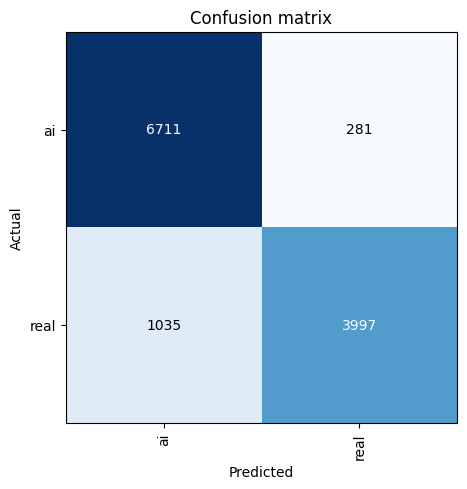

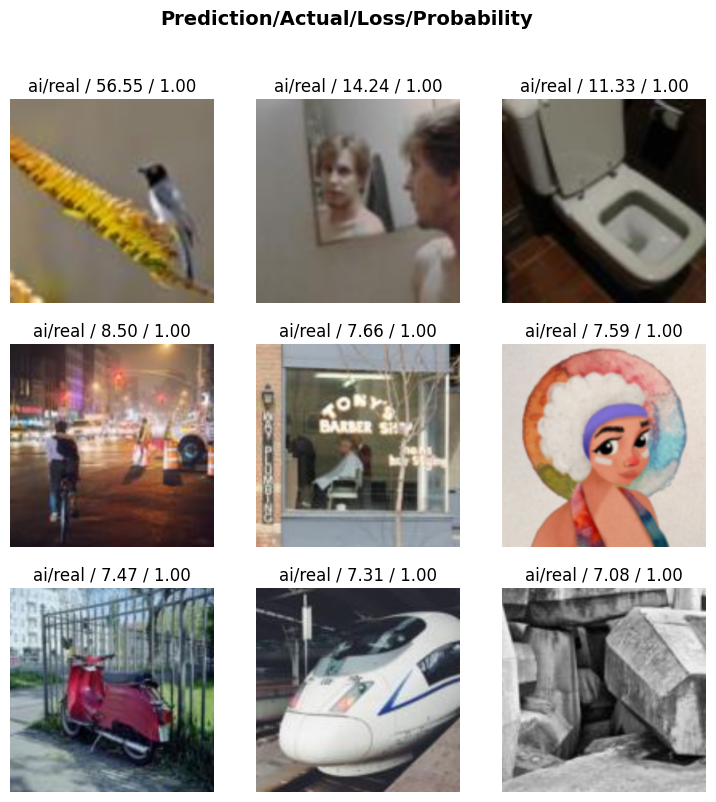

In [36]:
report_gpu()
#convnext_large_in22k
result = train('resnet50', 256, item=Resize((128, 128)), accum=1, epochs=8)

In [12]:
!head submission.csv

filename,class
4403.jpg,0
4222.jpg,0
2158.jpg,0
2257.jpg,0
2688.jpg,1
691.jpg,1
95.jpg,0
1931.jpg,0
2844.jpg,1


In [37]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('submission.csv', 'resnet50 128 8 ep', comp)

100%|██████████| 52.6k/52.6k [00:01<00:00, 53.5kB/s]
